<center><h2>Prediction on the Energy Consumption by a Building</h2></center>
<center><h4>Matt Sarmiento, Qingyi Sun, Lin Meng<center><h4>

<center><h2> Outline </h2></center>

1. Ask: How much energy will a building consume?
2. Acquire: Datasets including energy consumption, building and weather
3. Process: EDA, feature engineering and data merging
4. Model:
5. Deliver:

<center><h2>1. Ask: How much energy will a building consume?</h2></center>
  
We'd like to know whether investments being made to improve building efficiencies is actually effective at reducing costs and emissions.

<center><h2>2. Acquire: Datasets Introduction</h2></center>

- Data Source: Kaggle (ASHRAE - Great Energy Predictor III)
- 3 Datasets: meter, building, weather
- Number of Features Available: 16
- Number of Observations: 20M+

In [97]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from time import time
import datetime
import gc
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [171]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [189]:
# load data
train = pd.read_csv("data/train.csv", parse_dates=['timestamp'])
test = pd.read_csv("data/test.csv", parse_dates=['timestamp'])
building_metadata = pd.read_csv("data/building_metadata.csv")
weather_train = pd.read_csv("data/weather_train.csv", parse_dates=['timestamp'])
weather_test = pd.read_csv("data/weather_test.csv", parse_dates=['timestamp'])
sample_submission = pd.read_csv("data/sample_submission.csv")

<center><h2>3. Process: EDA, Feature Engineering and Data Merging</h2></center>

In [100]:
# meter_reading data
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [190]:
# replace the meter type: {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}
train["meter"].replace({0: "electricity", 1: "chilledwater", 2: "steam", 3: "hotwater"}, inplace=True)
test["meter"].replace({0: "electricity", 1: "chilledwater", 2: "steam", 3: "hotwater"}, inplace=True)

In [191]:
# mark the 0 values in meter_reading
train.loc[train.meter_reading == 0, "reading_0"] = 1
train.loc[train.meter_reading > 0, "reading_0"] = 0
# sort the 0-value ratios
id_meter_agg = train.groupby(["building_id", "meter"]).agg({"reading_0":["sum", "count"]}).reset_index()
id_meter_agg["ratio_0"] = id_meter_agg[("reading_0", "sum")] / id_meter_agg[("reading_0", "count")]
meter_ct = id_meter_agg.groupby("meter").agg({"ratio_0":"count"}).reset_index()

/anaconda3/envs/ml/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning:

using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))




Text(0, 0.5, 'Frequency')

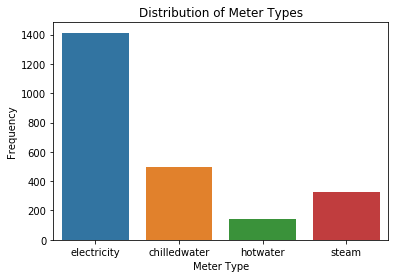

In [192]:
# distribution of meter types
sns.countplot(id_meter_agg['meter'])
plt.title("Distribution of Meter Types")
plt.xlabel("Meter Type")
plt.ylabel("Frequency")

In [85]:
# let's look at 4 examples
examples = [(53, "electricity"), (106, "hotwater"), (1346, "steam"), (1394, "chilledwater")]
viz_ratio_0 = train.set_index("timestamp")

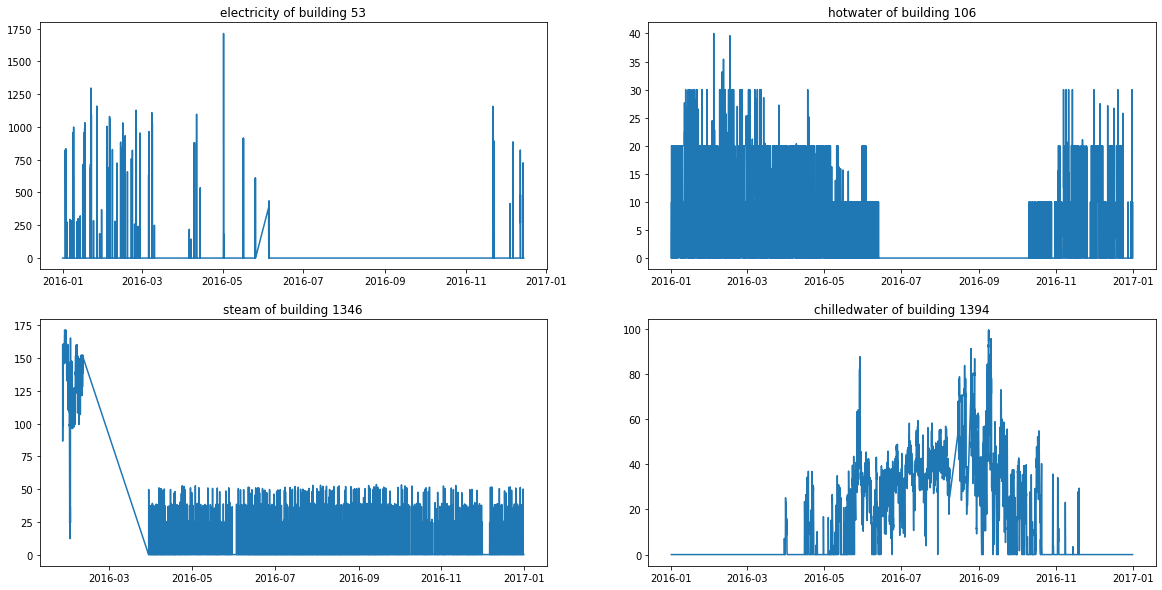

In [110]:
# time series with 0 meter_readings
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
idx = 0
for row in ax:
    for col in row:
        series = viz_ratio_0.loc[(viz_ratio_0.building_id == examples[idx][0]) & 
                                 (viz_ratio_0.meter == examples[idx][1]), 
                                 "meter_reading"]
        col.plot(series)
        col.title.set_text(f"{examples[idx][1]} of building {examples[idx][0]}")
        idx += 1
plt.show() 

Text(0.5, 1.0, 'log(meter_reading)')

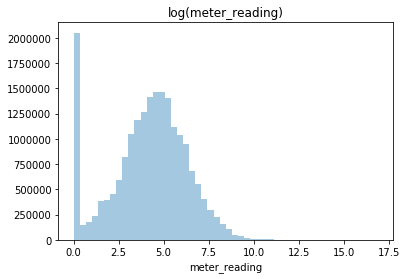

In [111]:
# meter_reading distribution
sns.distplot(np.log1p(train['meter_reading']), kde=False)
plt.title("log(meter_reading)")

In [112]:
# building data
building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [113]:
# missing values in building_metadata
building_metadata.isna().sum() / len(building_metadata)

site_id        0.000000
building_id    0.000000
primary_use    0.000000
square_feet    0.000000
year_built     0.534161
floor_count    0.755003
dtype: float64

In [114]:
use_ct = building_metadata.groupby("primary_use").agg({"building_id":"count"}) \
                          .reset_index().sort_values(by="building_id", ascending=False)
use_ct["ratio"] = use_ct["building_id"].apply(lambda x: x / use_ct["building_id"].sum())

Text(0, 0.5, 'Count')

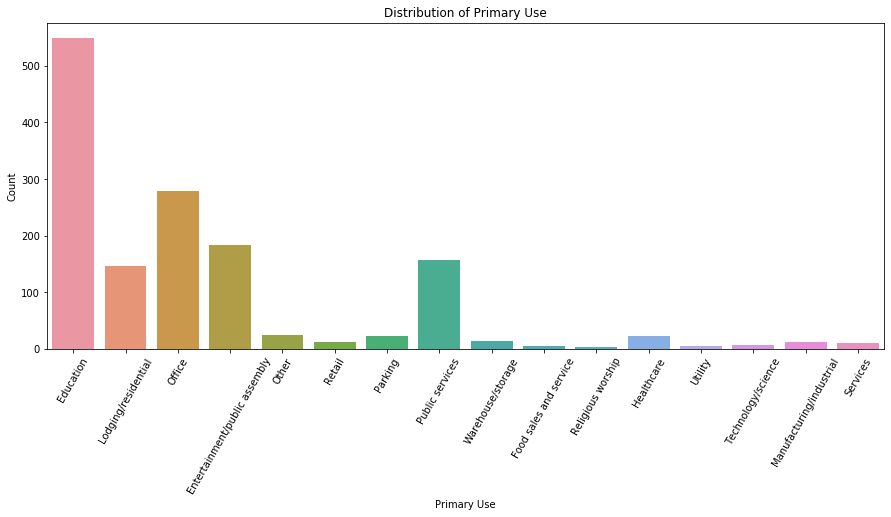

In [115]:
# distribution of primary_use
plt.figure(figsize=(15,6))
sns.countplot(building_metadata['primary_use'])
plt.title("Distribution of Primary Use")
plt.xlabel("Primary Use")
plt.xticks(rotation=60)
plt.ylabel("Count")

In [116]:
# weather data
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [117]:
# missing values in weather_train
weather_train.isna().sum() / len(weather_train)

site_id               0.000000
timestamp             0.000000
air_temperature       0.000393
cloud_coverage        0.494895
dew_temperature       0.000808
precip_depth_1_hr     0.359791
sea_level_pressure    0.075966
wind_direction        0.044844
wind_speed            0.002175
dtype: float64

For the target：
- Remove observations where 'meter_reading' is 0.
- Implement log_transformation.

For the features:
- Create time featurs like 'month', 'day of week' and 'hour'.
- Map minority classes to 'Other'.
- Convert 'year_built' to 'building_age'.
- Drop unpredictive features.
- Linearly interpolate the weather-related missing values.

In [210]:
def linear_interpolate(series):
    """Fill col NaNs with linearly interpolated values."""
    series.interpolate('linear', limit_direction='both', inplace=True)

def clean_weather_data(weather_df):
    """Prepare weather data for training."""
    # Drop unpredictive columns
    unpredictive_cols = ['sea_level_pressure', 'wind_direction', 'wind_speed']
    weather_df.drop(columns=unpredictive_cols, inplace=True)
    
    # Impute missing values per site
    weather_df.groupby('site_id').apply(linear_interpolate)
    
    # Fill remianing NaNs with -1.0 to signify missing data
    weather_df.fillna(-1.0, inplace=True)

def engineer_time(frame, time_col):
    """Split time into Year, Month, Dayofweek, & Hour cols and drop time."""
    time = frame[time_col]
    
#     frame['year'] = time.dt.year
    frame['month'] = time.dt.month
    frame['dayofweek'] = time.dt.dayofweek
    frame['hour'] = time.dt.hour
    
    frame.drop(columns=time_col, inplace=True)

In [194]:
# remove the 0 readings
train = train.loc[train.meter_reading > 0]
# log-transformation and drop columns
train.loc[:, "log_reading"] = np.log1p(train["meter_reading"])
target = train.pop("log_reading")
train = train.drop(["meter_reading", "reading_0"], axis=1)
# drop row_id in test set
test = test.drop("row_id", axis=1)

In [195]:
# assign other types
keep_use = ["Education", "Office", "Entertainment/public assembly", "Public services", "Lodging/residential"]
building_metadata.loc[~building_metadata.primary_use.isin(keep_use), "primary_use"] = "Other"
# convert year_built to age and fill the NAs
building_metadata.loc[:, "building_age"] = 2019 - building_metadata["year_built"]
age_median = building_metadata["building_age"].median()
building_metadata["building_age"].fillna(age_median, inplace=True)
# drop columns
building_metadata = building_metadata.drop(["year_built", "floor_count"], axis=1)

In [196]:
# process weather data
clean_weather_data(weather_train)
clean_weather_data(weather_test)

In [202]:
# issue: some site-time DO NOT have records
weather_train.groupby("site_id").agg({"timestamp":"count"})

,timestamp
site_id,
0,8784
1,8763
2,8783
3,8780
4,8783
5,8755
6,8782
7,8614
8,8784


In [203]:
# Merge the datasets
# %%time
train = pd.merge(train, building_metadata, on='building_id', how='left')
train = pd.merge(train, weather_train, on=['site_id','timestamp'], how='left')
print ("Training Data Shape {}".format(train.shape))
test = pd.merge(test, building_metadata, on='building_id', how='left')
test = pd.merge(test, weather_test, on=['site_id','timestamp'], how='left')
print ("Testing Data Shape {}".format(test.shape))
# gc.collect()

Training Data Shape (18342124, 11)
Testing Data Shape (41697600, 11)


In [211]:
# create time features
engineer_time(train, "timestamp")
engineer_time(test, "timestamp")
train.head()

,building_id,meter,site_id,primary_use,square_feet,building_age,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,month,dayofweek,hour
0,46,electricity,0,Other,9045,3.0,25.0,6.0,20.0,-1.0,1,4,0
1,74,electricity,0,Other,387638,22.0,25.0,6.0,20.0,-1.0,1,4,0
2,93,electricity,0,Office,33370,37.0,25.0,6.0,20.0,-1.0,1,4,0
3,105,electricity,1,Education,50623,49.0,3.8,-1.0,2.4,-1.0,1,4,0
4,106,electricity,1,Education,5374,49.0,3.8,-1.0,2.4,-1.0,1,4,0


<center><h2>4. Model: </h2></center>

In [217]:
# train test split
X_train, X_validate, y_train, y_validate = train_test_split(train, target, test_size=0.2, shuffle=True)

In [221]:
numeric_features = ["square_feet", "building_age", 
                    "air_temperature", "cloud_coverage", "dew_temperature", "precip_depth_1_hr", 
                    "month", "dayofweek", "hour"]
numeric_transformer = Pipeline(steps=[
    ("imputer", impute.SimpleImputer(strategy="median")),
    ("scaler", preprocessing.StandardScaler())
])

categorical_features = ["meter", "primary_use"]
categorical_transformer = Pipeline(steps=[
#     ("imputer", impute.SimpleImputer(strategy="constant", fill_value="unknown")),
#     ("onehot", preprocessing.OneHotEncoder(sparse=True))  # handle_unknown="ignore"
    ("label", preprocessing.OrdinalEncoder())
])

preprocessor = compose.ColumnTransformer(transformers=[
    ("numerical", numeric_transformer, numeric_features),
    ("categorical", categorical_transformer, categorical_features)
])

regressor = RandomForestRegressor(n_estimators=10,
                                  min_samples_leaf=168,
                                  random_state=42, 
                                  n_jobs=16)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", regressor)
])

In [222]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                       

In [234]:
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_validate)

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as

$\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$

In [235]:
rmsle_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"RMSLE for the training set is {rmsle_train}")
rmsle = np.sqrt(mean_squared_error(y_validate, y_pred))
print(f"RMSLE for the validation set is {rmsle}")

RMSLE for the training set is 0.4523826507382706
RMSLE for the validation set is 0.4563222425251665


In [237]:
X_train['primary_use'].unique()

array(['Education', 'Office', 'Entertainment/public assembly', 'Other',
       'Lodging/residential', 'Public services'], dtype=object)

In [238]:
y_pred_test = pipeline.predict(test)

In [243]:
sample_submission["meter_reading"] = y_pred_test

In [245]:
sample_submission.to_csv("data/ml_submission_1st.csv")

In [249]:
train.assign()

,building_id,meter,site_id,primary_use,square_feet,building_age,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,month,dayofweek,hour
0,46,electricity,0,Other,9045,3.0,25.0,6.0,20.0,-1.0,1,4,0
1,74,electricity,0,Other,387638,22.0,25.0,6.0,20.0,-1.0,1,4,0
2,93,electricity,0,Office,33370,37.0,25.0,6.0,20.0,-1.0,1,4,0
3,105,electricity,1,Education,50623,49.0,3.8,-1.0,2.4,-1.0,1,4,0
4,106,electricity,1,Education,5374,49.0,3.8,-1.0,2.4,-1.0,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18342119,1443,electricity,15,Education,40311,106.0,1.7,-1.0,-5.6,-1.0,12,5,23
18342120,1444,electricity,15,Entertainment/public assembly,19619,105.0,1.7,-1.0,-5.6,-1.0,12,5,23
18342121,1445,electricity,15,Education,4298,49.0,1.7,-1.0,-5.6,-1.0,12,5,23
18342122,1447,electricity,15,Lodging/residential,29775,18.0,1.7,-1.0,-5.6,-1.0,12,5,23
